# Tensorflow tutorial

## Import libraries

In [127]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt

In [128]:
print(tf.__version__)

2.16.1


## Set random state

In [129]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Load the data

In [130]:
data_dir = './data/aclImdb'

In [131]:
raw_training_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.


In [132]:
raw_validation_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


In [133]:
raw_test_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
)

Found 5000 files belonging to 2 classes.


## Investigate data

In [134]:
print(f'Label 0 corresponds to {raw_training_set.class_names[0]}')
print(f'Label 1 corresponds to {raw_training_set.class_names[1]}')

Label 0 corresponds to neg
Label 1 corresponds to pos


### Take one batch and investigate

In [135]:
for text_batch, label_batch in raw_training_set.take(1):
    for text, label in list(zip(text_batch, label_batch))[:3]:
        print(f'Label: {label}')
        print(f'Text:\n {text}')
        print("---------------------------")

Label: 1
Text:
 b'This is a reunion, a team, and a great episode of Justice. From hesitation to resolution, Clark has made a important leap from a troubled teenager who was afraid of a controlled destiny, to a Superman who, like Green Arrow, sets aside his emotions to his few loved ones, ready to save the whole planet. This is not just a thrilling story about teamwork, loyalty, and friendship; this is also about deciding what\'s more important in life, a lesson for Clark. I do not want the series to end, but I hope the ensuing episodes will strictly stick to what Justice shows without any "rewind" pushes and put a good end here of Smallville---and a wonderful beginning of Superman.<br /><br />In this episode, however, we should have seen more contrast between Lex and the Team. Nine stars should give it enough credit.'
---------------------------
Label: 1
Text:
 b'"Hey Babu Riba" is a film about a young woman, Mariana (nicknamed "Esther" after a famous American movie star), and four you

## Prepare the data

### Create custom function for cleaning input data

In [136]:
max_features = 1000

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    replaced = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return replaced

### Layer to convert text to vectors

In [137]:
vectorize_layer = layers.TextVectorization(standardize=custom_standardization, 
                                           max_tokens=max_features,
                                           output_mode='int',
                                           output_sequence_length=250)

### Build vocabulary

As the `raw_training_set` consist of both text and the labels and the `adapt` method of the `TextVectorization` class only takes the input text, we need to strip out the labels.

In [138]:
train_text = raw_training_set.map(lambda x, y: x)

In [139]:
vectorize_layer.adapt(train_text)

In [140]:
print(f'Vocabulary samples: {vectorize_layer.get_vocabulary()[0:20]}')

Vocabulary samples: ['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film']


In [141]:
print(f'Vocabulary length: {len(vectorize_layer.get_vocabulary())}')

Vocabulary length: 1000


### Accomodate for batches by adding a dimension to dataset

In [142]:
def vectorize_text(text, label):
    # Just transforms the data from a (x,) shape to (x, 1) shape as this is that the TextVectorization expects
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label # vectorize_layer takes one batch of size [32,1] and returns [32, 250] i.e string -> tokens

In [143]:
text_batch, label_batch = next(iter(raw_training_set))
first_review, first_label = text_batch[0], label_batch[0]

In [144]:
print(f'First review:\n:{first_review}')
print('---------------')
print(f'First label: {first_label}')
print('---------------')
print(f'Vectorized review 1:\n{vectorize_text(first_review, first_label)}')
print('---------------')

First review:
:b"This movie is about a side of Ireland that Americans don't normally see, the narrow-minded religiously prejudiced side of the 'friendliest race in the world'. The movie, by the admission of the inhabitants of Fethard who are old enough to remember the events, is fairly accurate (though they insist that the film-makers invented some of the more violent scenes just to spice up the action).<br /><br />The movie was very unpopular in Ireland as it portrayed the Catholic church in a bad light, but the simple fact is that representatives of the Catholic church *did* organise vetoes of minorities (before Protestants it was the Jews).<br /><br />The film is a fascinating insight into the whole issue of religion in Ireland"
---------------
First label: 1
---------------
Vectorized review 1:
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 10,  17,   7,  42,   3, 421,   5,   1,  12,   1,  87,   1,  65,
          2,   1,   1,   1, 421,   5,   2,   1,   1,   8,   2, 185, 

### Create final train/val/test set

In [145]:
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

### Configure dataset

In [146]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a sequential model

In [147]:
embedding_dim = 16

# Input for one batch: [32, 250]. Values are idx in the vocabulary
model_sequential = tf.keras.Sequential([
    # Shape [1000, 16].
    layers.Embedding(max_features, embedding_dim), 
    # Output from Embedding layer is [32, 250, 16] (it just pulls an embedding vector for all values)
    layers.GlobalAveragePooling1D(),
    # Output from Pooling layer. It goes from representing one embedding vector per token to one embedding vector per sequence
    # as it takes the average of embeddings vectors for each token in the sequence to build a embeddings vector per sequence
    # Output shape is now [32, 16]

    # The Dense layer has a weight matrix with shape [16,1]. Add the bias and  take the sigmoid
    # And you will have 32 classifications
    layers.Dense(1, activation='sigmoid')
])

model_sequential.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile model

In [148]:
model_sequential.compile(loss = losses.BinaryCrossentropy(),
                         optimizer='adam',
                         metrics = ['accuracy'])

## Create a model using the functional API

In [149]:
inputs = tf.keras.Input(shape=(None,))

embedding = layers.Embedding(max_features, embedding_dim)
x = embedding(inputs)

pooling = layers.GlobalAveragePooling1D()
x = pooling(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

In [150]:
model_functional = tf.keras.Model(inputs=inputs, outputs=outputs)
model_functional.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, None, 16)       │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,017 (62.57 KB)

 Trainable params: 16,017 (62.57 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
model_functional.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [152]:
model = model_sequential

In [153]:
epochs = 20

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)

Epoch 1/20
125/125 - 1s - 4ms/step - accuracy: 0.5285 - loss: 0.6912 - val_accuracy: 0.5940 - val_loss: 0.6867
Epoch 2/20
125/125 - 0s - 1ms/step - accuracy: 0.5870 - loss: 0.6838 - val_accuracy: 0.6170 - val_loss: 0.6773
Epoch 3/20
125/125 - 0s - 1ms/step - accuracy: 0.6248 - loss: 0.6720 - val_accuracy: 0.6780 - val_loss: 0.6622
Epoch 4/20
125/125 - 0s - 1ms/step - accuracy: 0.6630 - loss: 0.6541 - val_accuracy: 0.6970 - val_loss: 0.6415
Epoch 5/20
125/125 - 0s - 1ms/step - accuracy: 0.6845 - loss: 0.6318 - val_accuracy: 0.7100 - val_loss: 0.6180
Epoch 6/20
125/125 - 0s - 1ms/step - accuracy: 0.7063 - loss: 0.6072 - val_accuracy: 0.7310 - val_loss: 0.5935
Epoch 7/20
125/125 - 0s - 1ms/step - accuracy: 0.7318 - loss: 0.5816 - val_accuracy: 0.7550 - val_loss: 0.5695
Epoch 8/20
125/125 - 0s - 1ms/step - accuracy: 0.7525 - loss: 0.5561 - val_accuracy: 0.7710 - val_loss: 0.5470
Epoch 9/20
125/125 - 0s - 1ms/step - accuracy: 0.7725 - loss: 0.5319 - val_accuracy: 0.7840 - val_loss: 0.5268
E

In [154]:
loss, accuracy = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8117 - loss: 0.4244


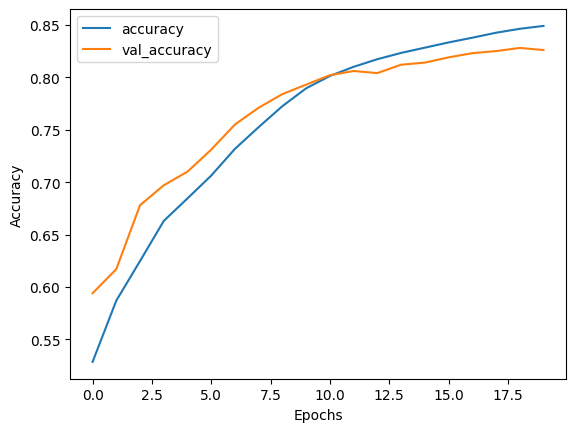

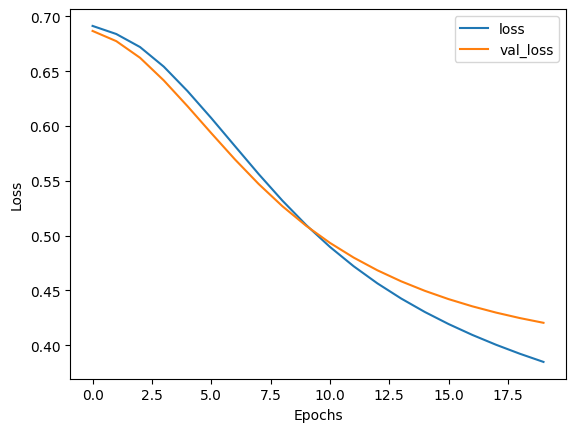

In [155]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")